In notebook #9, we explored the `ve7cc_dx.csv` dataset, and figured out how to add hourly solar elevation to it.  In this notebook, we'll try a model that uses that dataset and see how it performs.

As always, we start with the standard imports.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

# set seed for reproducibility
seed = 42
np.random.seed(seed)

To keep things simple, I will restrict to a single band (20m); I'll include all continents in the training data.

In [2]:
from src.data.load_dataset import load_dataset, load_and_count_by_band

import src.data.utils as utils

data_file = '../data/interim/ve7cc_dx.csv'
data_20m = load_and_count_by_band(data_file, 
                                  start_date='2018-01-01', 
                                  end_date='2019-06-30')
utils.add_solar_elevation(data_20m, city_name='Vancouver')
features_cnt = len(data_20m.columns) - 1

In [3]:
data_20m.head()
data_20m.tail()

total  sunspots_count  hour  month    annual  weekend  \
date                                                                         
2019-06-30 19:00:00      7               0    19      6  0.494536      1.0   
2019-06-30 20:00:00      3               0    20      6  0.494536      1.0   
2019-06-30 21:00:00      4               0    21      6  0.494536      1.0   
2019-06-30 22:00:00      5               0    22      6  0.494536      1.0   
2019-06-30 23:00:00      7               0    23      6  0.494536      1.0   

                     arrl_dx_contest  solar_elevation  
date                                                   
2019-06-30 19:00:00              0.0        59.859093  
2019-06-30 20:00:00              0.0        63.655173  
2019-06-30 21:00:00              0.0        62.463604  
2019-06-30 22:00:00              0.0        56.841543  
2019-06-30 23:00:00              0.0        48.663513

And because it's been a while, let's look at a pairplot:

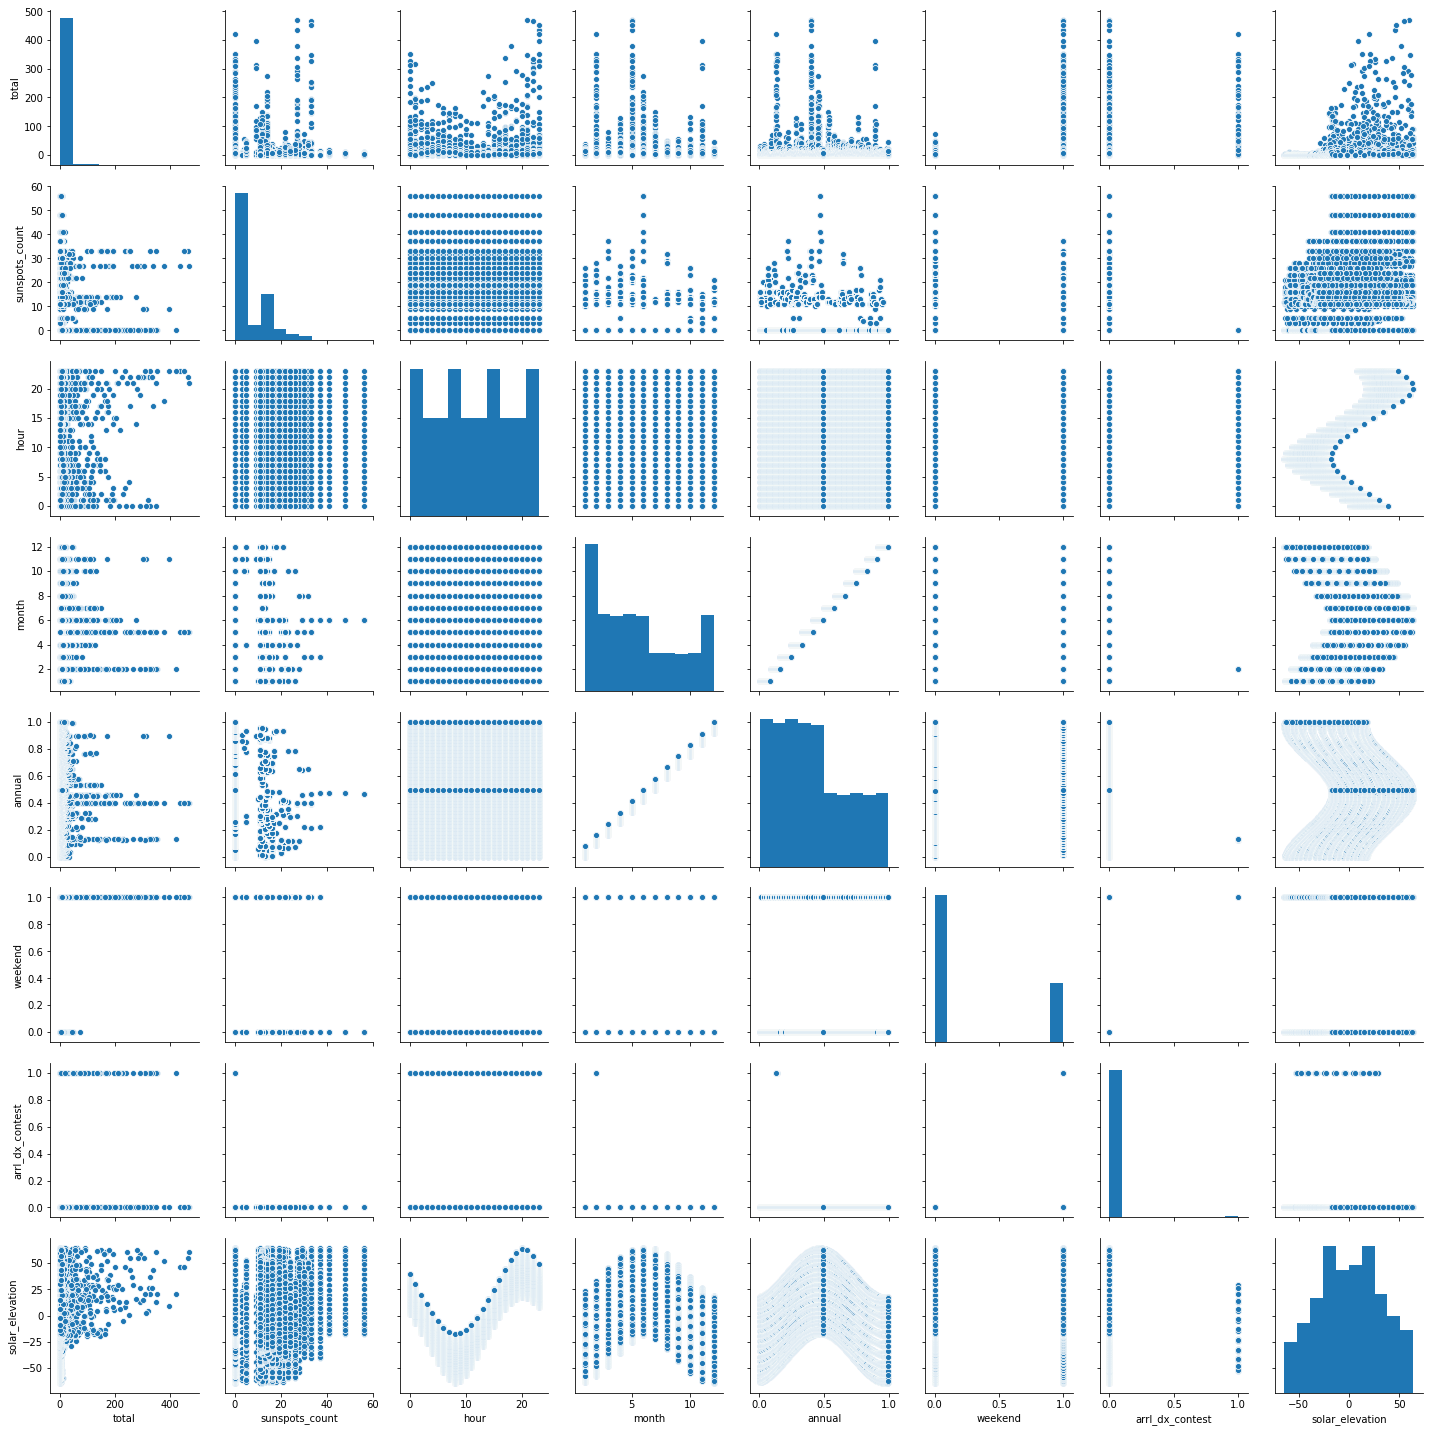

In [4]:
sns.pairplot(data_20m);

Looks good!  Let's proceed to build a model.  

In [5]:
features_cnt = len(data_20m.columns) - 1

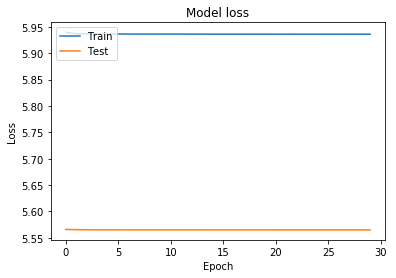

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers, regularizers

from src.data.utils import plot_keras_history

model = Sequential([
    Dense(32, input_shape=(features_cnt,)),
    Activation('relu'),
    Dense(1),
    Activation('tanh')
])

# Use the logcosh regression
model.compile(optimizer=optimizers.SGD(lr=0.01),
              loss='logcosh')

# Set verbose to 0; we'll graph our progress instead.
history = model.fit(x=data_20m.drop('total', axis=1),
                    y=data_20m['total'],
                    validation_split=0.2,
                    shuffle=True,
                    epochs=30,
                    verbose=0)

plot_keras_history(history)

Wow, that looks worse than what we saw in notebook #7.  Looking at [this article from Machine Learning Mastery](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/), this appears to be _underfit_: the model I created may not be able to capture the complexity of what's going on here.  (Interestingly, I've run this notebook a few different times before setting the random seed up above, and have sometimes seen slightly worse results: loss descending very slightly in a straight line, still between 5.5 and 6.)

Maybe it's worth trying this with just EU data.  Let's do that: EU, including sunspots, for the same 18-month period.

In [7]:
data_20m_eu = load_and_count_by_band(start_date='2018-01-01', 
                                     end_date='2019-06-30')
utils.add_solar_elevation(data_20m_eu, city_name='Vancouver')
features_cnt = len(data_20m_eu.columns) - 1

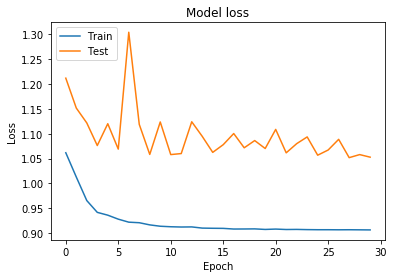

In [12]:
model_eu = Sequential([Dense(32, input_shape=(features_cnt,)),
                       Activation('relu'),
                       Dense(1),
                       Activation('tanh')])

# Use the logcosh regression
model_eu.compile(optimizer=optimizers.SGD(lr=0.01),
                 loss='logcosh')

# Set verbose to 0; we'll graph our progress instead.
history_eu = model_eu.fit(x=data_20m_eu.drop('total', axis=1),
                          y=data_20m_eu['total'],
                          validation_split=0.2,
                          shuffle=True,
                          epochs=30,
                          verbose=0)

plot_keras_history(history_eu)

Wow, that's dramatic. It looks to me like this neural network does well enough for EU data; my guess is that it would do well enough for a single continent (with roughly one set of things to worry about for propagation), but not for multiple continents.

# TODO
- **DONE:** Double check sunspots...everything is 0, and that looks wrong
  - Checked distribution (see below) and it's fine...it's just that our data is from the bottom of the sunspot cycle. :-) 
- **DONE:** Double check the annual feature; I'm not sure it's resetting at end of year, the way it should be.
- **DONE:** Figure out why sunrise time is wrong, at least for ARRL DX Contest dates...it doesn't rise at 08:00 UTC
- Try predictions! See how this behaves with the remaining 6 months of 2019
- Try xgboost